# Getting up to speed with DRL

In this notebook I provide a simple example of implementing a policy gradient Deep Reinforcement Learning algorithm to solve a control problem with continuous state space and discrete action space -- the venerable [CartPole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/). You should study the implementation in this notebook in preparation for the laboratory next Wednesday.

This notebook should run in an environment with at least the following packages installed (the gpu version of PyTorch is not mandatory):

     conda create -n DRL -c conda-forge gymnasium pytorch-gpu matplotlib pygame jupyterlab
     
Some background reading to get you started:

1. We will be using the [Gymnasium](https://gymnasium.farama.org/) framework for all of our experiments. This framework provides a consistent interface to a broad range of reinforcement learning environments (including CartPole). You should familiarize yourself with how it works, how environments are specified, how to instantiate them, and how to interact with them.

2. [This excellent blog post](http://karpathy.github.io/2016/05/31/rl/) is a great introduction to policy gradients, where they come from and how they work. Give it a read and I am sure it will help understand better what is going on in this notebook.

## Preliminaries

We start with our standard imports.

In [1]:
# Standard imports.
import numpy as np
import matplotlib.pyplot as plt
import gymnasium
import torch
import torch.nn as nn
import torch.nn.functional as F

# Plus one non standard one -- we need this to sample from policies.
from torch.distributions import Categorical

# This *might* help PyGame crash less...
import pygame
_ = pygame.init()

<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


And also some utility functions useful for what comes next.

In [2]:
# Given an environment, observation, and policy, sample from pi(a | obs). Returns the
# selected action and the log probability of that action (needed for policy gradient).
def select_action(env, obs, policy):
    dist = Categorical(policy(obs))
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return (action.item(), log_prob.reshape(1))

# Utility to compute the discounted total reward. Torch doesn't like flipped arrays, so we need to
# .copy() the final numpy array. There's probably a better way to do this.
def compute_returns(rewards, gamma):
    return np.flip(np.cumsum([gamma**(i+1)*r for (i, r) in enumerate(rewards)][::-1]), 0).copy()

# Given an environment and a policy, run it up to the maximum number of steps.
def run_episode(env, policy, maxlen=500):
    # Collect just about everything.
    observations = []
    actions = []
    log_probs = []
    rewards = []
    
    # Reset the environment and start the episode.
    (obs, info) = env.reset()
    for i in range(maxlen):
        # Get the current observation, run the policy and select an action.
        obs = torch.tensor(obs)
        (action, log_prob) = select_action(env, obs, policy)
        observations.append(obs)
        actions.append(action)
        log_probs.append(log_prob)
        
        # Advance the episode by executing the selected action.
        (obs, reward, term, trunc, info) = env.step(action)
        rewards.append(reward)
        if term or trunc:
            break
    return (observations, actions, torch.cat(log_probs), rewards)

## The Policy network

Here I provide a simple policy network which should work with any environment with continuous observations and discrete action spaces. Note how it uses the *specification* of the environment to configure its input and output spaces. 

In [3]:
# A simple, but generic, policy network with one hidden layer.
class PolicyNet(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], 128)
        self.fc2 = nn.Linear(128, env.action_space.n)
        
    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = F.softmax(self.fc2(s), dim=-1)
        return s

## The `REINFORCE` Algorithm

This is a very simple implementation of the most basic policy gradient DRL algorithm: `REINFORCE`. It is a very direct implementation of the policy gradient update (although I use Adam instead of SGD).

In [4]:
# A direct, inefficient, and probably buggy of the REINFORCE policy gradient algorithm.
def reinforce(policy, env, env_render=None, gamma=0.99, num_episodes=10):
    # The only non-vanilla part: we use Adam instead of SGD.
    opt = torch.optim.Adam(policy.parameters(), lr=1e-2)

    # Track episode rewards in a list.
    running_rewards = [0.0]
    
    # The main training loop.
    policy.train()
    for episode in range(num_episodes):
        # Run an episode of the environment, collect everything needed for policy update.
        (observations, actions, log_probs, rewards) = run_episode(env, policy)
        # Compute the discounted reward for every step of the episode. 
        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)
        # Keep a running average of total discounted rewards for the whole episode.
        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])
        print(log_probs.shape,log_probs.max(),log_probs.min())
        # Standardize returns.
        returns = (returns - returns.mean()) / returns.std()
        # Make an optimization step
        opt.zero_grad()
        loss = (-log_probs * returns).mean()
        print(f'Episode {episode}, Loss: {loss.item()}')

        loss.backward()
        for name, param in policy.named_parameters():
            if param.grad is not None:
                print(f'Gradient for {name}: {param.grad.norm().item()}')
        opt.step()
        
        # Render an episode after every 100 policy updates.
        if not episode % 100:
            if env_render:
                policy.eval()
                run_episode(env_render, policy)
                policy.train()
            print(f'Running reward: {running_rewards[-1]}')
    
    # Return the running rewards.
    policy.eval()
    return running_rewards

In [5]:
# Add compatibility for different NumPy versions
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

# Instantiate a (rendering) CartPole environment.
env_render = gymnasium.make('CartPole-v1', render_mode='human')
pygame.display.init()  # Might help PyGame not crash...

# Make a policy network and run a few episodes to see how well random initialization works.
policy = PolicyNet(env_render)
for _ in range(10):
    run_episode(env_render, policy,maxlen=1000)
    
# If you don't close the environment, the PyGame window stays visible.
env_render.close()

# Again we pray PyGame doesn't crash...
pygame.display.quit()

torch.Size([52]) tensor(-0.5593, grad_fn=<MaxBackward1>) tensor(-0.8495, grad_fn=<MinBackward1>)
Episode 0, Loss: 0.0068023731000721455
Gradient for fc1.weight: 0.026546576991677284
Gradient for fc1.bias: 0.02611197717487812
Gradient for fc2.weight: 0.23256033658981323
Gradient for fc2.bias: 0.05720098316669464
Running reward: 2.0148160934448245
torch.Size([30]) tensor(-0.4940, grad_fn=<MaxBackward1>) tensor(-0.9581, grad_fn=<MinBackward1>)
Episode 1, Loss: -0.04129428789019585
Gradient for fc1.weight: 0.10030333697795868
Gradient for fc1.bias: 0.06113168224692345
Gradient for fc2.weight: 0.7922154068946838
Gradient for fc2.bias: 0.16190460324287415
torch.Size([28]) tensor(-0.4653, grad_fn=<MaxBackward1>) tensor(-0.9194, grad_fn=<MinBackward1>)
Episode 2, Loss: -0.00900153536349535
Gradient for fc1.weight: 0.013807246461510658
Gradient for fc1.bias: 0.014051605015993118
Gradient for fc2.weight: 0.06945296376943588
Gradient for fc2.bias: 0.011169900186359882
torch.Size([36]) tensor(-0.2

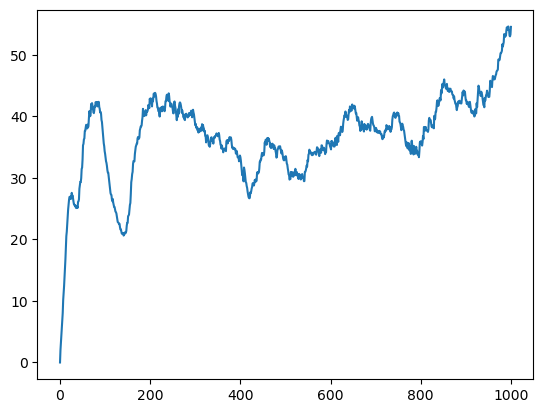

In [6]:
# In the new version of Gymnasium you need different environments for rendering and no rendering.
# Here we instaintiate two versions of cartpole, one that animates the episodes (which slows everything
# down), and another that does not animate.
seed = 2112
torch.manual_seed(seed)
np.random.seed(seed)

env = gymnasium.make('CartPole-v1')
env.reset(seed=seed)
env_render = gymnasium.make('CartPole-v1', render_mode='human')

# PyGame, please don't crash.
pygame.display.init()

# Make a policy network.
policy = PolicyNet(env)

# Train the agent.
plt.plot(reinforce(policy, env, env_render, num_episodes=1000))

# Close up everything
env_render.close()
env.close()
pygame.display.quit()  # Fingers crossed...

In [7]:
# And run the final agent for a few episodes.
env_render = gymnasium.make('CartPole-v1', render_mode='human')
for _ in range(10):
    run_episode(env_render, policy)
env_render.close()

## For your consideration

There are many things that can be improved in this example. Some things you can think about:

1. **Development Environment**. If there is *one* laboratory for which you don't use a Jupyter Notebook, *this should definitely be the one*. PyGame (for visualizing episodes in the environment) interacts very badly with the Jupyter Python kernels at times. Consider using PyCharm or VSCode.
 
2. **Better Logging**. Monitoring just a moving average return is a pretty coarse metric of performance -- one that with also *depend on the discount factor $\gamma$*. Think about what might be better statistics to collect and report, and also *how to collect and report them*. You should think about using Weights and Biases or Tensorboard for this.

3. **Checkpointing**. When training is unstable, it can be a good idea to *checkpoint* your models both periodically (so you can restart training from a specific checkpoint) and for each *best* model as determined by you running performance measure(s). 

4. **Exploration**. The model is probably overfitting (or perhaps remaining too *plastic*, which can explain the unstable convergence). Our policy is *always* stochastic in that we sample from the output distribution. It would be interesting to add a temperature parameter to the policy so that we can control this behavior, or even implement a deterministic policy sampler that always selects the action with max probability to evaluate the quality of the learned policy network.

5. **Discount Factor**: The discount factor (default $\gamma = 0.99$) is an important hyperparameter that has an effect on the stability of training. Try different values for $\gamma$ and see how it affects training. Can you think of other ways to stabilize training?